<a href="https://colab.research.google.com/github/OxyzGiaHuy/BCCD/blob/main/BCCD_with_DETR_MoE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DETR vs DETR-MoE Comparison on BCCD Dataset

This notebook compares the performance of the standard DETR model with a modified version incorporating Mixture of Experts (MoE) layers in the Transformer's Feed-Forward Networks (FFNs). The comparison is performed on the Blood Cell Count and Detection (BCCD) dataset.

**Steps:**
1. Setup: Install libraries, clone DETR repo.
2. Dataset: Download BCCD, prepare Dataset/DataLoader.
3. Models: Define Standard DETR and DETR-MoE for BCCD.
4. Training & Evaluation Utilities: Implement training and COCO evaluation loops.
5. Experiment 1: Train and evaluate standard DETR.
6. Experiment 2: Train and evaluate DETR-MoE.
7. Comparison: Summarize results.

In [22]:
!git clone https://github.com/Shenggan/BCCD_Dataset.git

fatal: destination path 'BCCD_Dataset' already exists and is not an empty directory.


In [23]:
!pip install -q --upgrade transformers datasets evaluate timm albumentations pycocotools

In [24]:
# %% Setup - Imports
import os
import numpy as np
import torch
import torchvision
import xml.etree.ElementTree as ET
from PIL import Image
import random
import json
from pathlib import Path
import time
from tqdm.notebook import tqdm

from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from transformers import DetrImageProcessor, DetrConfig, DetrForObjectDetection, Trainer, TrainingArguments
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

import torch.nn as nn
import torch.nn.functional as F
import gc # Garbage collection

# Set seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cuda


In [25]:
class BCCDDataset(Dataset):
    """
    BCCD Dataset Class.
    Reads images and annotations (Pascal VOC format) from the BCCD dataset.
    """
    def __init__(self, image_dir, annot_dir, image_set_path, processor, transforms=None, name_to_id=None):
        self.image_dir = Path(image_dir)
        self.annot_dir = Path(annot_dir)
        self.processor = processor
        self.transforms = transforms
        self.name_to_id = name_to_id if name_to_id else {'RBC': 1, 'WBC': 2, 'Platelets': 3}
        self.id_to_name = {v: k for k, v in self.name_to_id.items()}
        self.id_to_label = {0: 'background'} | self.id_to_name
        self.label_to_id = {k: v for v, k in self.id_to_label.items()}

        with open(image_set_path, "r") as f:
            self.image_ids_str = [line.strip() for line in f.readlines()]

        self.annotations = self._load_annotations()

        self.image_ids_str = [img_id for img_id in self.image_ids_str if img_id in self.annotations]
        print(f"Loaded {len(self.image_ids_str)} images from {image_set_path}")
        print(f"Class mapping (excluding background for file loading): {self.name_to_id}")
        print(f"Full label map (including background for model): {self.id_to_label}")
        print(f"First 5 image IDs: {self.image_ids_str[:5]}")


    def _load_annotations(self):
        annotations = {}
        for image_id_str in tqdm(self.image_ids_str, desc="Loading Annotations"):
            annot_path = self.annot_dir / f"{image_id_str}.xml"
            if not annot_path.exists():
                #  print(f"Warning: Annotation file not found {annot_path}")
                 annotations[image_id_str] = {'boxes': torch.empty((0, 4), dtype=torch.float32),
                                              'labels': torch.empty((0,), dtype=torch.int64),
                                              'size': (0,0)}
                 continue

            tree = ET.parse(annot_path)
            root = tree.getroot()

            size_elem = root.find("size")
            img_w = int(size_elem.find("width").text)
            img_h = int(size_elem.find("height").text)

            boxes = []
            labels = []
            for obj in root.findall("object"):
                name = obj.find("name").text
                if name not in self.name_to_id:
                    #  print(f"Warning: Unknown class '{name}' in {annot_path}. Skipping.")
                     continue # Skip unknown classes

                bndbox = obj.find("bndbox")
                xmin = int(bndbox.find("xmin").text)
                ymin = int(bndbox.find("ymin").text)
                xmax = int(bndbox.find("xmax").text)
                ymax = int(bndbox.find("ymax").text)

                # Basic validation
                if xmin >= xmax or ymin >= ymax or xmin < 0 or ymin < 0 or xmax > img_w or ymax > img_h:
                    print(f"Warning: Invalid box coordinates {name}: {[xmin, ymin, xmax, ymax]} in {annot_path} (Image size {img_w}x{img_h}). Skipping.")
                    continue

                if xmax - xmin <= 1 or ymax - ymin <= 1: # Skip tiny boxes
                    # print(f"Warning: Tiny box {name}: {[xmin, ymin, xmax, ymax]} in {annot_path}. Skipping.") # Too verbose
                    continue

                boxes.append([xmin, ymin, xmax, ymax])
                labels.append(self.name_to_id[name])

            annotations[image_id_str] = {
                'boxes': torch.tensor(boxes, dtype=torch.float32) if boxes else torch.empty((0, 4), dtype=torch.float32),
                'labels': torch.tensor(labels, dtype=torch.int64) if labels else torch.empty((0,), dtype=torch.int64),
                'size': torch.tensor([img_h, img_w], dtype=torch.int64) # Store as H, W tensor
            }
        return annotations

    def __len__(self):
        return len(self.image_ids_str)

    def __getitem__(self, idx):
        image_id_str = self.image_ids_str[idx]
        img_path = self.image_dir / f"{image_id_str}.jpg"
        image = Image.open(img_path).convert("RGB")
        # width, height = image.size
        original_size = self.annotations[image_id_str]['size'].clone().detach().to(dtype=torch.int64) # Use size from loaded annotation


        # Ensure annotations were loaded correctly
        if image_id_str not in self.annotations:
             # This shouldn't happen after filtering image_ids_str in __init__
             # but good practice to raise error if it does.
             raise KeyError(f"Annotations for {image_id_str} not found in pre-loaded dict.")

        target = self.annotations[image_id_str]

        # Convert boxes from [xmin, ymin, xmax, ymax] (Pascal VOC) to required format
        # The processor expects {'image_id': int, 'annotations': [{'bbox': [xmin, ymin, width, height], 'category_id': int, 'area': float, 'iscrowd': 0}]}
        # Note: The HuggingFace processor handles box conversion internally if given in COCO format!
        formatted_annotations = []
        for box, label in zip(target['boxes'], target['labels']):
            xmin, ymin, xmax, ymax = box.tolist()
            width = xmax - xmin
            height = ymax - ymin
            # COCO format: [xmin, ymin, width, height]
            if width > 0 and height > 0: # Only add valid boxes
                 area = width * height
                 formatted_annotations.append({
                     "bbox": [xmin, ymin, width, height], # COCO format
                     "category_id": label.item(),
                     "area": area,
                     "iscrowd": 0,
                     "image_id": image_id_str # <-- FIX: Use the original image_id_str here
                 })

        target_dict_for_processor = {
            "image_id": idx, # <-- FIX: Use the original image_id_str here too (redundant but good)
            "annotations": formatted_annotations,
            "size": original_size.tolist() # Processor expects size as list [H, W]
        }

        # Apply Albumentations transforms if provided (using Pascal VOC format for input)
        # Note: Albumentations outputs will also be in Pascal VOC format
        img_np = np.array(image)
        boxes_pascal = target['boxes'].tolist()
        labels_list = target['labels'].tolist()

        # Apply Albumentations transforms if provided
        if self.transforms:
            try:
                transform_input = {
                    'image': img_np,
                    'bboxes': boxes_pascal,
                    'class_labels': labels_list
                }
                transformed = self.transforms(**transform_input)
                img_np = transformed['image']
                transformed_boxes_pascal = transformed['bboxes']
                transformed_labels_list = transformed['class_labels']

                # Reformat transformed boxes/labels back into the target dictionary for the processor
                formatted_annotations_transformed = []
                # new_height, new_width = image.shape[1], image.shape[2] # Get size from tensor C, H, W
                for box, label in zip(transformed_boxes_pascal, transformed_labels_list):
                    xmin, ymin, xmax, ymax = box
                    width = xmax - xmin
                    height = ymax - ymin
                    if width > 0 and height > 0:
                        area = width * height
                        formatted_annotations_transformed.append({
                            "bbox": [xmin, ymin, width, height],
                            "category_id": label,
                            "area": area,
                            "iscrowd": 0,
                            "image_id": image_id_str
                        })
                target_dict_for_processor["annotations"] = formatted_annotations_transformed
                # The image is already a tensor due to ToTensorV2
                # Apply processor normalization etc *after* albumentations augmentation
                # But the processor usually expects a PIL image or numpy array.
                # Let's convert back for the processor, then it handles final tensor conversion+normalization
                # image = Image.fromarray(image.permute(1, 2, 0).numpy()) # Convert back to HWC PIL/numpy format if needed by processor

            except Exception as e:
                print(f"Error applying transforms to {image_id_str}: {e}. Using original data.")
                # If transform fails, proceed with original data loaded earlier
                img_np = np.array(Image.open(img_path).convert("RGB")) # Ensure img_np is original
                target_dict_for_processor["annotations"] = formatted_annotations # Ensure annotations are original

        # Use DetrImageProcessor to prepare image and targets for the model
        # It handles resizing, normalization, and converts targets to the required format
        # {'pixel_values': ..., 'pixel_mask': ..., 'labels': [{'class_labels': ..., 'boxes': ...}] }
        encoding = self.processor(images=img_np, annotations=target_dict_for_processor, return_tensors="pt")

        # The processor returns data in a batch format, squeeze out the batch dim
        pixel_values = encoding["pixel_values"].squeeze(0)
        pixel_mask = encoding["pixel_mask"].squeeze(0)
        labels = encoding["labels"][0] # Access the labels for the first (and only) image in the batch

        return {
            "pixel_values": pixel_values,
            "pixel_mask": pixel_mask,
            "labels": labels, # This dict contains 'class_labels', 'boxes', 'image_id' (value from target_dict_for_processor)
            "orig_size": original_size, # Original size tensor [H, W]
            "image_id_str": image_id_str # <-- Add image_id_str here explicitly for collate/eval
            }

In [26]:
# Define Albumentations transforms
# DETR models are typically trained with resizing and normalization.
# Color jitter is often beneficial.
# Note: DETR uses specific normalization constants. The processor handles this.
# We focus on geometric augmentations here.

def get_train_transforms():
    return A.Compose([
        A.HorizontalFlip(p=0.5),
        A.Rotate(limit=10, p=0.3), # Reduced rotate limit
        A.RandomBrightnessContrast(p=0.1),
        A.ColorJitter(p=0.1),
    ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels'], min_area=1.0, min_visibility=0.0))

def get_val_test_transforms():
    # No augmentation for validation/test, only return numpy array
    return A.Compose([

    ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))


In [27]:
# Collate function
def train_eval_collate_fn(batch):
    pixel_values = torch.stack([item["pixel_values"] for item in batch])
    pixel_mask = torch.stack([item["pixel_mask"] for item in batch])
    labels = [item["labels"] for item in batch] # Keep labels as a list of dicts

    # Only return items needed by the model's forward pass + labels for loss
    # The Trainer will pass these as keyword arguments to model.forward(**batch_dict)
    return {
        'pixel_values': pixel_values,
        'pixel_mask': pixel_mask,
        'labels': labels, # Trainer needs this for loss calculation
        # Do NOT include 'orig_size' or 'image_id_str' here
    }

# Collate function for manual evaluation loop (test set)
# This provides all information needed for inference, post-processing, and COCO formatting.
def test_collate_fn(batch):
     pixel_values = torch.stack([item["pixel_values"] for item in batch])
     pixel_mask = torch.stack([item["pixel_mask"] for item in batch])
     labels = [item["labels"] for item in batch] # Keep labels as a list of dicts
     orig_sizes = torch.stack([item["orig_size"] for item in batch])
     image_id_strs = [item["image_id_str"] for item in batch]

     # Return all needed info, including extra keys for evaluation logic
     return {
         'pixel_values': pixel_values,
         'pixel_mask': pixel_mask,
         'labels': labels, # Still include labels, useful potentially, but orig_sizes/image_id_strs are the critical extras
         'orig_sizes': orig_sizes, # Needed for post-processing
         'image_id_strs': image_id_strs # Needed for COCO formatting
     }

# Helper to create COCO-style annotation file for evaluation
def convert_to_coco_format(dataset, output_file):
    """Converts dataset annotations to COCO format JSON."""
    coco_output = {
        "images": [],
        "annotations": [],
        "categories": [{"id": v, "name": k, "supercategory": "cell"} for k, v in dataset.name_to_id.items()]
    }
    ann_id_counter = 1
    for idx in tqdm(range(len(dataset)), desc=f"Converting {Path(output_file).name} to COCO format"):
        image_id_str = dataset.image_ids_str[idx] # Use the original image_id_str
        img_data = dataset.annotations[image_id_str] # Get pre-loaded data
        img_h, img_w = img_data['size'].tolist() # Get size from tensor

        coco_output["images"].append({
            "id": image_id_str, # Use index as image ID for consistency with __getitem__
            "file_name": f"{image_id_str}.jpg",
            "height": img_h,
            "width": img_w,
        })

        boxes_pascal = img_data['boxes'] # Format [xmin, ymin, xmax, ymax]
        labels = img_data['labels']

        for box, label in zip(boxes_pascal, labels):
            xmin, ymin, xmax, ymax = box.tolist()
            width = xmax - xmin
            height = ymax - ymin
            if width <= 0 or height <= 0: # Skip invalid boxes
                continue
            coco_bbox = [xmin, ymin, width, height] # COCO format [xmin, ymin, width, height]
            area = width * height

            coco_output["annotations"].append({
                "id": ann_id_counter,
                "image_id": image_id_str, # Match image id
                "category_id": label.item(),
                "bbox": coco_bbox,
                "area": area,
                "iscrowd": 0,
                # "segmentation": [], # Object detection doesn't need segmentation
            })
            ann_id_counter += 1

    Path(output_file).parent.mkdir(parents=True, exist_ok=True)
    with open(output_file, "w") as f:
        json.dump(coco_output, f, indent=4)
    print(f"Saved COCO format annotations to {output_file}")

In [28]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches # Import the patches module

# Helper to visualize annotations/predictions
def plot_detections(image_path, annotations=None, predictions=None, id_to_label=None, score_threshold=0.7):
    """
    Plots an image with bounding boxes.
    Args:
        image_path (Path or str): Path to the image file.
        annotations (dict or None): Ground truth annotations {'boxes': [[x1,y1,x2,y2],...], 'labels': [id,...]} (Pascal VOC format).
        predictions (dict or None): Model predictions {'boxes': [[x1,y1,x2,y2],...], 'scores': [s,...], 'labels': [id,...]} (Pascal VOC format).
        id_to_label (dict): Mapping from label ID to name.
        score_threshold (float): Minimum score to display prediction boxes.
    """
    image = Image.open(image_path).convert("RGB")
    plt.figure(figsize=(12, 12))
    ax = plt.gca()
    ax.imshow(image)

    if id_to_label is None:
        id_to_label = {0: 'background', 1: 'RBC', 2: 'WBC', 3: 'Platelets'} # Default for BCCD

    # Plot ground truth boxes
    if annotations and len(annotations.get('boxes', [])) > 0:
        for box, label_id in zip(annotations['boxes'], annotations['labels']):
            xmin, ymin, xmax, ymax = box
            rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                     linewidth=1, edgecolor='g', facecolor='none')
            ax.add_patch(rect)
            label_name = id_to_label.get(int(label_id) if isinstance(label_id, torch.Tensor) else label_id, f'ID {label_id}')
            ax.text(xmin, ymin - 5, f'{label_name} GT', color='g', fontsize=8, bbox=dict(facecolor='white', alpha=0.7, pad=0))

    # Plot predicted boxes
    if predictions and len(predictions.get('boxes', [])) > 0:
         scores = predictions.get('scores', [])
         labels = predictions.get('labels', [])
         boxes = predictions.get('boxes', [])
         # Filter by score threshold
         filtered_preds = [(s, l, b) for s, l, b in zip(scores, labels, boxes) if s >= score_threshold]

         if filtered_preds:
             for score, label_id, box in filtered_preds:
                 xmin, ymin, xmax, ymax = box
                 rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                          linewidth=1, edgecolor='r', facecolor='none', linestyle='dashed')
                 ax.add_patch(rect)
                 label_name = id_to_label.get(label_id, f'ID {label_id}')
                 ax.text(xmin, ymax + 5, f'{label_name}: {score:.2f}', color='r', fontsize=8, bbox=dict(facecolor='white', alpha=0.7, pad=0))


    plt.axis('off')
    plt.title(f"Detections for {Path(image_path).name}")
    plt.show()

In [29]:
# --- Define paths and Parameters ---
DATA_DIR = Path("/content/BCCD_Dataset/BCCD")
IMAGE_DIR = DATA_DIR / "JPEGImages"
ANNOT_DIR = DATA_DIR / "Annotations"
IMAGE_SETS_DIR = DATA_DIR / "ImageSets" / "Main"

TRAIN_SET_PATH = IMAGE_SETS_DIR / "train.txt"
VAL_SET_PATH = IMAGE_SETS_DIR / "val.txt"
TEST_SET_PATH = IMAGE_SETS_DIR / "test.txt"

# Use standard DETR processor
PRETRAINED_MODEL_NAME = "facebook/detr-resnet-50"
image_processor = DetrImageProcessor.from_pretrained(PRETRAINED_MODEL_NAME)

# Define Label Mapping (must be consistent)
CLASS_NAMES = ['RBC', 'WBC', 'Platelets']
LABEL_MAP_CATEGORY_ID = {'RBC': 1, 'WBC': 2, 'Platelets': 3}
ID_TO_LABEL_WITH_BACKGROUND = {0: 'background', 1: 'RBC', 2: 'WBC', 3: 'Platelets'}
LABEL_TO_ID_WITH_BACKGROUND = {v:k for k,v in ID_TO_LABEL_WITH_BACKGROUND.items()}

# Create Datasets
print("Creating Training Dataset...")
train_dataset = BCCDDataset(
    image_dir=IMAGE_DIR,
    annot_dir=ANNOT_DIR,
    image_set_path=TRAIN_SET_PATH,
    processor=image_processor,
    transforms=get_train_transforms(), # Enable if needed, but processor handles resize/norm
    name_to_id=LABEL_MAP_CATEGORY_ID
)

print("\nCreating Validation Dataset...")
val_dataset = BCCDDataset(
    image_dir=IMAGE_DIR,
    annot_dir=ANNOT_DIR,
    image_set_path=VAL_SET_PATH,
    processor=image_processor,
    transforms=get_val_test_transforms(), # No augmentation
    name_to_id=LABEL_MAP_CATEGORY_ID
)

print("\nCreating Test Dataset...")
test_dataset = BCCDDataset(
    image_dir=IMAGE_DIR,
    annot_dir=ANNOT_DIR,
    image_set_path=TEST_SET_PATH,
    processor=image_processor,
    transforms=get_val_test_transforms(), # No augmentation
    name_to_id=LABEL_MAP_CATEGORY_ID
)

# Check dataset sizes
print(f"\nDataset sizes: Train={len(train_dataset)}, Val={len(val_dataset)}, Test={len(test_dataset)}")

Creating Training Dataset...


Loading Annotations:   0%|          | 0/205 [00:00<?, ?it/s]

Loaded 205 images from /content/BCCD_Dataset/BCCD/ImageSets/Main/train.txt
Class mapping (excluding background for file loading): {'RBC': 1, 'WBC': 2, 'Platelets': 3}
Full label map (including background for model): {0: 'background', 1: 'RBC', 2: 'WBC', 3: 'Platelets'}
First 5 image IDs: ['BloodImage_00001', 'BloodImage_00003', 'BloodImage_00004', 'BloodImage_00005', 'BloodImage_00006']

Creating Validation Dataset...


/usr/local/lib/python3.11/dist-packages/albumentations/core/composition.py:331: UserWarning: Got processor for bboxes, but no transform to process it.
  self._set_keys()


Loading Annotations:   0%|          | 0/87 [00:00<?, ?it/s]

Loaded 87 images from /content/BCCD_Dataset/BCCD/ImageSets/Main/val.txt
Class mapping (excluding background for file loading): {'RBC': 1, 'WBC': 2, 'Platelets': 3}
Full label map (including background for model): {0: 'background', 1: 'RBC', 2: 'WBC', 3: 'Platelets'}
First 5 image IDs: ['BloodImage_00000', 'BloodImage_00002', 'BloodImage_00014', 'BloodImage_00017', 'BloodImage_00028']

Creating Test Dataset...


Loading Annotations:   0%|          | 0/72 [00:00<?, ?it/s]

Loaded 72 images from /content/BCCD_Dataset/BCCD/ImageSets/Main/test.txt
Class mapping (excluding background for file loading): {'RBC': 1, 'WBC': 2, 'Platelets': 3}
Full label map (including background for model): {0: 'background', 1: 'RBC', 2: 'WBC', 3: 'Platelets'}
First 5 image IDs: ['BloodImage_00007', 'BloodImage_00011', 'BloodImage_00015', 'BloodImage_00016', 'BloodImage_00018']

Dataset sizes: Train=205, Val=87, Test=72


Label map verified.

Visualizing a sample from the training dataset (original image + GT boxes):


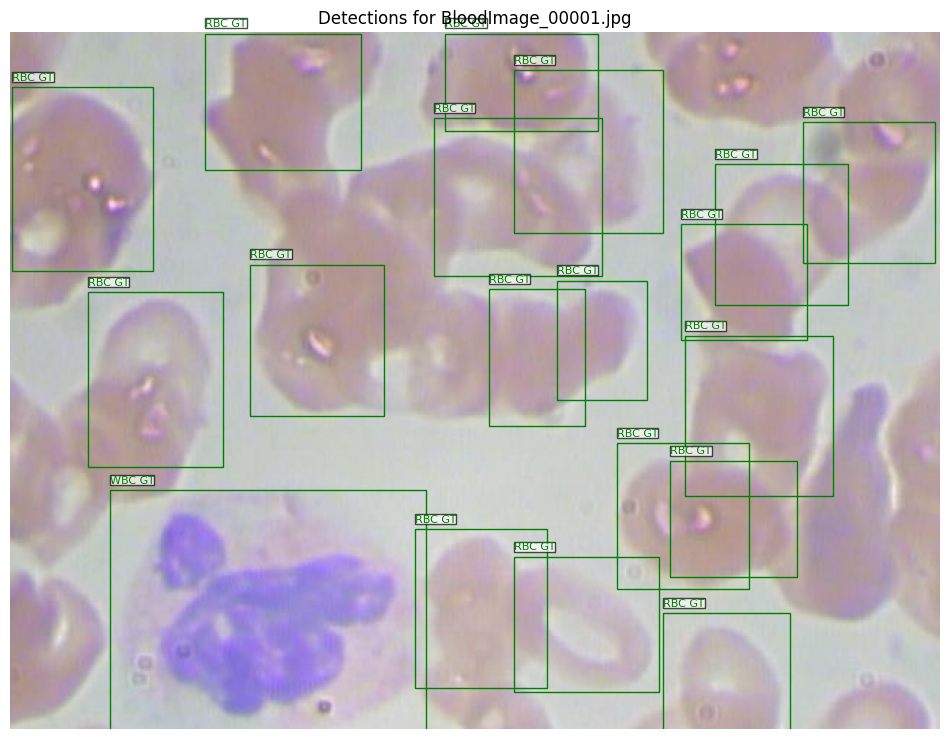

In [30]:
# Verify label mapping consistency
assert train_dataset.name_to_id == LABEL_MAP_CATEGORY_ID
assert val_dataset.name_to_id == LABEL_MAP_CATEGORY_ID
assert test_dataset.name_to_id == LABEL_MAP_CATEGORY_ID
assert train_dataset.id_to_label == ID_TO_LABEL_WITH_BACKGROUND # Check full map including background
print("Label map verified.")

# Visualize a sample from the training dataset (before processor transformation)
print("\nVisualizing a sample from the training dataset (original image + GT boxes):")
sample_idx = 0
sample_item = train_dataset[sample_idx]
sample_image_id_str = sample_item['image_id_str']
sample_original_target = train_dataset.annotations[sample_image_id_str] # Get original annotations

# Load original image again for visualization
sample_image_path = IMAGE_DIR / f"{sample_image_id_str}.jpg"

plot_detections(
    sample_image_path,
    annotations={'boxes': sample_original_target['boxes'], 'labels': sample_original_target['labels']},
    id_to_label=train_dataset.id_to_label # Use the full ID to label map
)

In [31]:
# Convert validation and test sets to COCO format for evaluation
VAL_COCO_ANNOT_FILE = "./val_coco_annotations.json"
TEST_COCO_ANNOT_FILE = "./test_coco_annotations.json"
convert_to_coco_format(val_dataset, VAL_COCO_ANNOT_FILE)
convert_to_coco_format(test_dataset, TEST_COCO_ANNOT_FILE)

Converting val_coco_annotations.json to COCO format:   0%|          | 0/87 [00:00<?, ?it/s]

Saved COCO format annotations to ./val_coco_annotations.json


Converting test_coco_annotations.json to COCO format:   0%|          | 0/72 [00:00<?, ?it/s]

Saved COCO format annotations to ./test_coco_annotations.json


In [32]:
# -------------------------------------
# Cell 3: moe_layer.py (Revised for simplicity and direct use of DetrMLP)
# -------------------------------------
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers.models.detr.modeling_detr import DetrMLPPredictionHead, DetrConfig # Need config for DetrMLP defaults if not passed


class MoEFFN(nn.Module):
    """
    Mixture of Experts FFN Layer: replaces (fc1 -> activation -> fc2) block.
    Each expert is (fc1 -> activation -> fc2).
    """
    def __init__(self, input_dim, hidden_dim, num_experts, activation_fn=nn.ReLU()):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_experts = num_experts
        self.activation_fn = activation_fn

        self.gate = nn.Linear(input_dim, num_experts)

        # Each expert is a sequential: fc1 -> activation -> fc2
        self.experts = nn.ModuleList([
            nn.Sequential(
                nn.Linear(input_dim, hidden_dim),
                self._clone_activation(), # ensure separate instances
                nn.Linear(hidden_dim, input_dim)
            ) for _ in range(num_experts)
        ])

    def _clone_activation(self):
        """Clone activation function to avoid shared states."""
        return type(self.activation_fn)()

    def forward(self, hidden_states):
        """
        Args:
            hidden_states: (batch_size, seq_len, input_dim)
        Returns:
            (batch_size, seq_len, input_dim)
        """
        batch_size, seq_len, dim = hidden_states.shape
        hidden_states_flat = hidden_states.view(-1, dim) # (batch*seq_len, dim)

        # Gating
        gate_logits = self.gate(hidden_states_flat) # (batch*seq_len, num_experts)
        gate_weights = F.softmax(gate_logits, dim=-1)

        # Expert outputs
        expert_outputs = []
        for expert in self.experts:
            expert_outputs.append(expert(hidden_states_flat)) # (batch*seq_len, dim)

        expert_outputs_stacked = torch.stack(expert_outputs, dim=1) # (batch*seq_len, num_experts, dim)

        final_output_flat = torch.sum(gate_weights.unsqueeze(-1) * expert_outputs_stacked, dim=1) # (batch*seq_len, dim)

        final_output = final_output_flat.view(batch_size, seq_len, dim)

        return final_output

In [33]:
# -------------------------------------
# Cell 4: detr_moe.py
# -------------------------------------
import torch
import torch.nn as nn
from transformers import DetrForObjectDetection, DetrConfig
# from moe_layer import MoEFFN # Assuming MoEFFN is defined in moe_layer.py or previous cell

def replace_ffn_with_moe(model: DetrForObjectDetection, num_experts: int):
    """
    Replaces (fc1 -> activation -> fc2) blocks in encoder and decoder layers with MoEFFN.
    """
    config = model.config
    d_model = config.d_model
    encoder_hidden_dim = getattr(config, 'encoder_ffn_dim', d_model * 4)
    decoder_hidden_dim = getattr(config, 'decoder_ffn_dim', d_model * 4)

    print(f"Replacing FFN with MoE (num_experts={num_experts})...")
    device = next(model.parameters()).device

    # Encoder
    if hasattr(model.model.encoder, 'layers'):
        print(f"Found {len(model.model.encoder.layers)} encoder layers.")
        for i, layer in enumerate(model.model.encoder.layers):
            if hasattr(layer, 'fc1') and hasattr(layer, 'fc2'):
                print(f"Replacing Encoder Layer {i} FFN with MoEFFN.")

                # Ensure the original activation function is correctly captured if it's a module
                original_activation = layer.activation_fn
                if not isinstance(original_activation, nn.Module):
                     # Handle cases where activation_fn might be a functional (like F.relu)
                     # Defaulting to nn.ReLU() here, adjust if needed based on actual config
                     print(f"Warning: Encoder Layer {i} activation_fn is not an nn.Module ({type(original_activation)}). Using nn.ReLU for MoE experts.")
                     original_activation = nn.ReLU()

                moe_ffn = MoEFFN(
                    input_dim=d_model,
                    hidden_dim=encoder_hidden_dim,
                    num_experts=num_experts,
                    activation_fn=original_activation
                ).to(device)

                layer.fc1 = moe_ffn
                # Replace activation and fc2 with Identity to pass the MoE output through
                # Make sure Identity layers are also on the correct device
                layer.activation_fn = nn.Identity().to(device)
                layer.fc2 = nn.Identity().to(device)

                print(f" - Replaced fc1 with MoEFFN({num_experts} experts) on device {layer.fc1.gate.weight.device}")
                print(f" - Set activation_fn to Identity")
                print(f" - Set fc2 to Identity")

            else:
                print(f"Warning: Encoder Layer {i} missing standard FFN attributes (fc1, fc2, activation_fn). Skipping replacement.")
    else:
        print("Warning: No encoder layers found or attribute 'layers' missing.")

    # Decoder
    if hasattr(model.model.decoder, 'layers'):
        print(f"Found {len(model.model.decoder.layers)} decoder layers.")
        for i, layer in enumerate(model.model.decoder.layers):
             # Check for the main FFN components in decoder layers
             if hasattr(layer, 'fc1') and hasattr(layer, 'fc2') and hasattr(layer, 'activation_fn'):
                print(f"Replacing Decoder Layer {i} FFN components with MoEFFN.")
                original_activation = layer.activation_fn
                if not isinstance(original_activation, nn.Module):
                     print(f"Warning: Decoder Layer {i} activation_fn is not an nn.Module ({type(original_activation)}). Using nn.ReLU for MoE experts.")
                     original_activation = nn.ReLU()

                moe_ffn = MoEFFN(
                    input_dim=d_model,
                    hidden_dim=decoder_hidden_dim,
                    num_experts=num_experts,
                    activation_fn=original_activation
                ).to(device) # Move the new module to the correct device

                layer.fc1 = moe_ffn
                layer.activation_fn = nn.Identity().to(device)
                layer.fc2 = nn.Identity().to(device)

                print(f" - Replaced fc1 with MoEFFN({num_experts} experts) on device {layer.fc1.gate.weight.device}")
                print(f" - Set activation_fn to Identity")
                print(f" - Set fc2 to Identity")
             else:
                 print(f"Warning: Decoder Layer {i} missing standard FFN attributes (fc1, fc2, activation_fn). Skipping replacement.")
    else:
        print("Warning: No decoder layers found or attribute 'layers' missing.")

    print("FFN component replacement complete.")
    return model

In [34]:
# -------------------------------------
# Cell 5: engine.py (Evaluation Logic)
# -------------------------------------
import torch
from tqdm.notebook import tqdm
import json
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import numpy as np
import os

def prepare_for_coco_detection(predictions, processor, id_to_label):
    """Converts model outputs to COCO format for evaluation."""
    coco_results = []
    background_id = 0
    for image_id_str, prediction in predictions.items():
        if prediction is None or 'scores' not in prediction or len(prediction['scores']) == 0:
            continue

        scores = prediction['scores'].tolist()
        labels = prediction['labels'].tolist()
        boxes = prediction['boxes'].tolist() # Expected format [xmin, ymin, xmax, ymax]

        for score, label_id, box in zip(scores, labels, boxes):
            if label_id == background_id:
                continue
            # Ensure box is in [xmin, ymin, width, height] format for COCO
            xmin, ymin, xmax, ymax = box
            width = xmax - xmin
            height = ymax - ymin
            if width <= 0 or height <= 0:
                continue
            coco_box = [xmin, ymin, width, height]

            result = {
                'image_id': image_id_str, # Must match the image_id in the ground truth COCO file
                'category_id': label_id,
                'bbox': coco_box,
                'score': score,
            }
            coco_results.append(result)
    return coco_results

def compute_coco_metrics(model, processor, dataloader, coco_gt_file, device, id_to_label):
    """Runs inference and computes COCO metrics."""
    model.eval()
    model.to(device)
    all_predictions = {}

    print(f"Loading ground truth from {coco_gt_file}")
    try:
        coco_gt = COCO(coco_gt_file)
    except Exception as e:
        print(f"Error loading ground truth file {coco_gt_file}: {e}")
        print("Cannot compute COCO metrics.")
        return {"mAP": 0.0, "mAP_50": 0.0, "mAP_75": 0.0, "error": f"Failed to load GT: {e}"}

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            # Retrieve original image IDs and sizes from the batch
            image_id_strs = batch['image_id_strs'] # <-- Get original image_id_strs
            orig_sizes = batch['orig_sizes'].to(device) # Original image sizes [H, W]

            pixel_values = batch["pixel_values"].to(device)
            pixel_mask = batch["pixel_mask"].to(device)

            # Ensure the model is explicitly in eval mode
            model.eval()
            outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask)

            # Post-process results
            results = processor.post_process_object_detection(
                outputs,
                threshold=0.01, # Use a threshold appropriate for evaluation
                target_sizes=orig_sizes
            ) # List of dicts per image: {'scores', 'labels', 'boxes'}

            # Store predictions mapped by their original image ID
            for img_id_str, res in zip(image_id_strs, results):
                all_predictions[img_id_str] = res


    # Convert predictions to COCO format
    coco_formatted_preds = prepare_for_coco_detection(all_predictions, processor, id_to_label)

    if not coco_formatted_preds:
        print("No predictions generated above threshold=0.01 after post-processing. Returning zero metrics.")
        return {"mAP": 0.0, "mAP_50": 0.0, "mAP_75": 0.0}

    # Save predictions to a temp file
    results_file = "coco_predictions.json"
    try:
        with open(results_file, "w") as f:
            json.dump(coco_formatted_preds, f, indent=4)
        print(f"Saved {len(coco_formatted_preds)} predictions to {results_file}")
    except Exception as e:
        print(f"Error saving predictions to {results_file}: {e}")
        return {"mAP": 0.0, "mAP_50": 0.0, "mAP_75": 0.0, "error": f"Failed to save preds: {e}"}

    # Load predictions using COCO API
    try:
        coco_dt = coco_gt.loadRes(results_file)
    except Exception as e:
        print(f"Error loading prediction results into pycocotools from {results_file}: {e}")
        print("This might happen if the JSON format is incorrect or empty.")
        # os.remove(results_file) # Clean up temp file even on error
        return {"mAP": 0.0, "mAP_50": 0.0, "mAP_75": 0.0, "error": f"Failed loadRes: {e}"}

    # Run COCO evaluation
    print("Running COCO evaluation...")
    coco_eval = COCOeval(coco_gt, coco_dt, 'bbox')

    try:
        coco_eval.evaluate()
        coco_eval.accumulate()
        print("\nCOCO Evaluation Summary:")
        coco_eval.summarize()

        # Extract key metrics (mAP at IoU=0.50:0.95, mAP at IoU=0.50, mAP at IoU=0.75)
        # Index 0: Mean AP @ IoU=[0.50:0.95], area=all, maxDets=100
        # Index 1: Mean AP @ IoU=0.50, area=all, maxDets=100
        # Index 2: Mean AP @ IoU=0.75, area=all, maxDets=100
        map_iou_50_95 = coco_eval.stats[0]
        map_iou_50 = coco_eval.stats[1]
        map_iou_75 = coco_eval.stats[2]

        metrics = {
            "mAP": round(map_iou_50_95, 4),
            "mAP_50": round(map_iou_50, 4),
            "mAP_75": round(map_iou_75, 4),
        }
        print(f"Computed Metrics: {metrics}")

    except Exception as e:
        print(f"Error during COCO evaluation: {e}")
        metrics = {"mAP": 0.0, "mAP_50": 0.0, "mAP_75": 0.0, "error": f"Eval failed: {e}"}

    return metrics

In [35]:
# -------------------------------------
# Cell 6: Main Training and Comparison
# -------------------------------------
from transformers import TrainingArguments, Trainer
import evaluate # Hugging Face Evaluate library
import gc
import os

# --- Configuration ---
OUTPUT_DIR_BASE = "./detr_bccd_results"
NUM_TRAIN_EPOCHS = 2
PER_DEVICE_TRAIN_BATCH_SIZE = 4 # Adjust based on GPU memory
PER_DEVICE_EVAL_BATCH_SIZE = 4
LEARNING_RATE = 1e-4 # Standard DETR LR
WEIGHT_DECAY = 1e-4
LOGGING_STEPS = 50
EVAL_STEPS = 200 # Evaluate less frequently maybe
SAVE_STEPS = 200 # Save checkpoints less frequently
GRAD_ACCUM_STEPS = 2 # Use gradient accumulation if batch size is small

NUM_EXPERTS_MOE = 4 # Number of experts for the MoE model

# --- Helper Function for Trainer ---
# Define compute_metrics function for Hugging Face Trainer
# The default Trainer expects metrics during training based on eval_dataset.
# It passes 'eval_pred' which contains predictions and labels.
# However, COCO evaluation needs the whole dataset processed.
# We will run our custom COCO evaluation *after* training.
# The simple_compute_metrics is mainly for Trainer's internal logging (e.g., eval_loss).
def simple_compute_metrics(eval_pred):
    # This function runs on a *batch* during Trainer's eval_strategy.
    # It's not suitable for full COCO mAP calculation.
    # We can compute batch loss here if needed, but the Trainer already logs it.
    # Return an empty dict or a simple placeholder.
    return {} # No metrics computed here


# --- Training Function ---
def train_model(
    model_name_or_path, model_output_dir, model_init_config,
    image_processor, train_dataset, val_dataset, test_dataset, is_moe=False, num_experts=0
    ):
    print(f"\n--- Training Model: {'DETR+MoE' if is_moe else 'Standard DETR'} ---")
    print(f"Initialization: {model_init_config['type']}")
    print(f"Output Dir: {model_output_dir}")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 1. Load Model Configuration
    config = DetrConfig.from_pretrained(
        model_name_or_path,
        # num_labels should match the number of classes *including* background for the model's classification head
        num_labels=len(ID_TO_LABEL_WITH_BACKGROUND),
        id2label=ID_TO_LABEL_WITH_BACKGROUND,
        label2id=LABEL_TO_ID_WITH_BACKGROUND,
        ignore_mismatched_sizes=True # Important if changing num_labels
    )
    print(f"Model config num_labels: {config.num_labels}")

    # 2. Instantiate Model based on config and initialization strategy
    model = None
    if model_init_config["type"] == "full_pretrained":
        print(f"Loading fully pre-trained weights from {model_name_or_path}")
        model = DetrForObjectDetection.from_pretrained(
            model_name_or_path,
            config=config,
            ignore_mismatched_sizes=True # Allow mismatch in classification head
        )

        model.to(device)
        print(f"Model moved to {device}")

    elif model_init_config["type"] == "pretrained_backbone_random_transformer":
        print(f"Loading pre-trained backbone, random transformer from {model_name_or_path}")
        # Load config first, then instantiate with random weights based on config
        model = DetrForObjectDetection(config) # This initializes all weights randomly

        model.to(device)
        print(f"Empty model moved to {device} before loading backbone.")

        # Load only the backbone weights from the pre-trained model
        pretrained_model = DetrForObjectDetection.from_pretrained(model_name_or_path, map_location='cpu')
        print("Loading pre-trained backbone state dict...")
        model.model.backbone.load_state_dict(pretrained_model.model.backbone.state_dict())
        print("Backbone weights loaded.")
        del pretrained_model # Free up memory
        gc.collect()
        torch.cuda.empty_cache()

        # Transformer encoder/decoder/head weights remain randomly initialized by default
        print("Transformer encoder, decoder, and head weights remain randomly initialized.")

    elif model_init_config["type"] == "random_init":
         print("Loading model with random weights (using config)")
         # Note: This initializes backbone randomly too, unless config specifies otherwise
         model = DetrForObjectDetection(config)
         model.to(device)
         print(f"Model loaded and moved to {device}")
    else:
        raise ValueError(f"Unknown model_init_config type: {model_init_config['type']}")

    # model.to(device)
    # print(f"Model moved to {device}")

    # 3. Apply MoE if specified
    if is_moe:
        if next(model.parameters()).device.type == 'meta':
            raise RuntimeError("Model parameters are still on meta device before MoE replacement!")
        model = replace_ffn_with_moe(model, num_experts)
        print(f"MoE layers integrated with {num_experts} experts.")



    # 4. Training Arguments
    training_args = TrainingArguments(
        output_dir=model_output_dir,
        num_train_epochs=NUM_TRAIN_EPOCHS,
        per_device_train_batch_size=PER_DEVICE_TRAIN_BATCH_SIZE,
        per_device_eval_batch_size=PER_DEVICE_EVAL_BATCH_SIZE,
        gradient_accumulation_steps=GRAD_ACCUM_STEPS,
        learning_rate=LEARNING_RATE,
        weight_decay=WEIGHT_DECAY,
        lr_scheduler_type="cosine", # Or "linear"
        logging_dir=f"{model_output_dir}/logs",
        logging_steps=LOGGING_STEPS,
        do_eval=True,
        eval_strategy="steps", # Evaluate periodically
        save_strategy="steps",
        save_steps=SAVE_STEPS,
        eval_steps=EVAL_STEPS,
        save_total_limit=3, # Keep more checkpoints maybe
        load_best_model_at_end=True, # Load best model based on eval metric
        metric_for_best_model="eval_loss", # Use eval loss reported by Trainer (or implement custom metric)
        greater_is_better=False, # Lower loss is better
        # metric_for_best_model="mAP", # Requires custom integration with compute_metrics
        report_to="tensorboard", # or "wandb"
        fp16=torch.cuda.is_available(), # Use mixed precision if available
        push_to_hub=False,
        remove_unused_columns=False, # Important for DETR labels format
    )

    # 5. Initialize Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset, # Use validation set for evaluation during training
        tokenizer=image_processor, # Pass processor as tokenizer for consistency
        data_collator=train_eval_collate_fn,
        compute_metrics=simple_compute_metrics, # Use simple one for Trainer, run full eval later
    )

    # 6. Train
    print("Starting training...")
    train_start_time = time.time()
    train_result = trainer.train()
    train_end_time = time.time()
    print(f"Training finished in {train_end_time - train_start_time:.2f} seconds.")

    # Log training metrics
    metrics = train_result.metrics
    trainer.log_metrics("train", metrics)
    trainer.save_metrics("train", metrics)
    trainer.save_state()

    # 7. Save final model and processor
    print("\nSaving final model...")
    final_model_dir = os.path.join(model_output_dir, "final_model")
    trainer.save_model(final_model_dir)
    if image_processor:
        image_processor.save_pretrained(final_model_dir)
    print(f"Final model saved to {final_model_dir}")

    # 8. Evaluate on Test Set using COCO metrics
    print("\nEvaluating on Test Set...")
    # Load the best model saved by the Trainer (based on eval_loss)
    best_model_checkpoint_path = trainer.state.best_model_checkpoint
    loaded_model_path = best_model_checkpoint_path if best_model_checkpoint_path else final_model_dir

    if loaded_model_path:
        print(f"Loading model for test evaluation from: {loaded_model_path}")
        try:
             # Need to load the model structure correctly, especially if MoE was applied
             # The config should be saved with the model.
             model_to_eval = DetrForObjectDetection.from_pretrained(loaded_model_path)
             model_to_eval.to(DEVICE)
             # If MoE layers were saved correctly, they should be loaded.
             # Basic check:
             has_moe_encoder = any(isinstance(l.ffn, MoEFFN) for l in model_to_eval.model.encoder.layers if hasattr(l, 'ffn'))
             has_moe_decoder = any(isinstance(l.ffn, MoEFFN) for l in model_to_eval.model.decoder.layers if hasattr(l, 'ffn'))
             print(f"Loaded model has MoE layers (Encoder): {has_moe_encoder}, (Decoder): {has_moe_decoder}")
             # If somehow not loaded, re-apply, but this indicates a saving/loading issue
             # if is_moe and (not has_moe_encoder or not has_moe_decoder):
             #      print("Warning: MoE layers not detected in loaded checkpoint, attempting to re-apply.")
             #      model_to_eval = replace_ffn_with_moe(model_to_eval, num_experts)

             loaded_processor = DetrImageProcessor.from_pretrained(loaded_model_path)

        except Exception as e:
             print(f"Error loading model from {loaded_model_path}: {e}")
             print("Cannot perform test evaluation.")
             return {"mAP": 0.0, "mAP_50": 0.0, "mAP_75": 0.0, "error": f"Failed to load model for eval: {e}"}
    else:
        print("No model found to load for test evaluation.")
        return {"mAP": 0.0, "mAP_50": 0.0, "mAP_75": 0.0, "error": "No model saved/loaded"}


    test_dataloader = DataLoader(test_dataset, batch_size=PER_DEVICE_EVAL_BATCH_SIZE, collate_fn=test_collate_fn)

    # --- Debugging Step: Visualize Predictions ---
    print("\nVisualizing predictions on a sample from the Test Set...")
    sample_eval_batch = next(iter(test_dataloader))
    # Take the first image from the batch
    sample_image_id_str = sample_eval_batch['image_id_strs'][0]
    sample_pixel_values = sample_eval_batch['pixel_values'][0].unsqueeze(0).to(DEVICE) # Add batch dim
    sample_pixel_mask = sample_eval_batch['pixel_mask'][0].unsqueeze(0).to(DEVICE)
    sample_orig_size = sample_eval_batch['orig_sizes'][0].unsqueeze(0).to(DEVICE) # Add batch dim


    model_to_eval.eval()
    with torch.no_grad():
        sample_outputs = model_to_eval(pixel_values=sample_pixel_values, pixel_mask=sample_pixel_mask)
        sample_results = loaded_processor.post_process_object_detection(
            sample_outputs,
            threshold=0.5, # Use a higher threshold for visualization clarity
            target_sizes=sample_orig_size
        )[0] # Get results for the single image


    # Need the original image path for plotting
    sample_image_path_for_plot = test_dataset.image_dir / f"{sample_image_id_str}.jpg"
    # Need original GT annotations for plotting
    sample_original_target_for_plot = test_dataset.annotations[sample_image_id_str]


    # Convert predicted boxes back to Pascal VOC format [x1, y1, x2, y2] for plotting function
    # The processor outputs [x1, y1, x2, y2] in absolute coordinates already! Good.
    sample_predictions_for_plot = {
        'boxes': sample_results['boxes'].tolist(),
        'scores': sample_results['scores'].tolist(),
        'labels': sample_results['labels'].tolist() # These are category_ids (1, 2, 3)
    }

    plot_detections(
        sample_image_path_for_plot,
        annotations={'boxes': sample_original_target_for_plot['boxes'].tolist(), 'labels': sample_original_target_for_plot['labels'].tolist()},
        predictions=sample_predictions_for_plot,
        id_to_label=test_dataset.id_to_label, # Use the full ID to label map
        score_threshold=0.5 # Visualize with a higher score threshold
    )
    # End Debugging Step

    test_metrics = compute_coco_metrics(
        model=model_to_eval,
        processor=loaded_processor,
        dataloader=test_dataloader,
        coco_gt_file=TEST_COCO_ANNOT_FILE,
        device=DEVICE,
        id_to_label=test_dataset.id_to_label
    )
    print(f"Test Set Metrics: {test_metrics}")

    # Clean up memory
    del model_to_eval, trainer
    gc.collect()
    torch.cuda.empty_cache()

    return test_metrics

results = {}

In [36]:
# --- Select which experiments to run ---
# Choose one or two to start, as training DETR takes time.
# Let's start by debugging the standard DETR to ensure the pipeline works.

print("\n\n === Running Experiment 1: Standard DETR (Fully Pre-trained) ===")
init_config_1 = {"type": "full_pretrained"}
output_dir_1 = os.path.join(OUTPUT_DIR_BASE, "detr_standard_full_pretrained")
results["detr_standard_full_pretrained"] = train_model(
    model_name_or_path=PRETRAINED_MODEL_NAME,
    model_output_dir=output_dir_1,
    model_init_config=init_config_1,
    image_processor=image_processor,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    test_dataset=test_dataset,
    is_moe=False
)



 === Running Experiment 1: Standard DETR (Fully Pre-trained) ===

--- Training Model: Standard DETR ---
Initialization: full_pretrained
Output Dir: ./detr_bccd_results/detr_standard_full_pretrained
Model config num_labels: 4
Loading fully pre-trained weights from facebook/detr-resnet-50


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:2397: UserWarning: for conv1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:2397: UserWarning: for bn1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:2397: UserWarning: for bn1.bias: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pas

Model moved to cuda
Starting training...


<ipython-input-35-be19178e7d4e>:143: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss


KeyboardInterrupt: 

In [ ]:
# --- Print Final Results Summary ---
print("\n\n--- Final Comparison Results ---")
for config_name, metrics in results.items():
    print(f"\nConfiguration: {config_name}")
    if metrics and "error" not in metrics:
        print(f"  mAP (IoU .50-.95): {metrics.get('mAP', 'N/A')}")
        print(f"  mAP (IoU .50):     {metrics.get('mAP_50', 'N/A')}")
        print(f"  mAP (IoU .75):     {metrics.get('mAP_75', 'N/A')}")
        if "notes" in metrics:
             print(f"  Notes: {metrics['notes']}")
    elif "error" in metrics:
         print(f"  Evaluation Error: {metrics['error']}")
    else:
        print("  Metrics not available (training/evaluation might have failed).")

In [ ]:

print("\n\n === Running Experiment 2: DETR + MoE (Fully Pre-trained Base) ===")
init_config_2 = {"type": "full_pretrained"}
output_dir_2 = os.path.join(OUTPUT_DIR_BASE, f"detr_moe_{NUM_EXPERTS_MOE}exp_full_pretrained")
results[f"detr_moe_{NUM_EXPERTS_MOE}exp_full_pretrained"] = train_model(
    model_name_or_path=PRETRAINED_MODEL_NAME,
    model_output_dir=output_dir_2,
    model_init_config=init_config_2,
    image_processor=image_processor,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    test_dataset=test_dataset,
    is_moe=True,
    num_experts=NUM_EXPERTS_MOE
)



 === Running Experiment 2: DETR + MoE (Fully Pre-trained Base) ===

--- Training Model: DETR+MoE ---
Initialization: full_pretrained
Output Dir: ./detr_bccd_results/detr_moe_4exp_full_pretrained
Model config num_labels: 4
Loading fully pre-trained weights from facebook/detr-resnet-50


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:2397: UserWarning: for conv1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:2397: UserWarning: for bn1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:2397: UserWarning: for bn1.bias: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pas

Model moved to cuda
Replacing FFN with MoE (num_experts=4)...
Found 6 encoder layers.
Replacing Encoder Layer 0 FFN with MoEFFN.
 - Replaced fc1 with MoEFFN(4 experts) on device cuda:0
 - Set activation_fn to Identity
 - Set fc2 to Identity
Replacing Encoder Layer 1 FFN with MoEFFN.
 - Replaced fc1 with MoEFFN(4 experts) on device cuda:0
 - Set activation_fn to Identity
 - Set fc2 to Identity
Replacing Encoder Layer 2 FFN with MoEFFN.
 - Replaced fc1 with MoEFFN(4 experts) on device cuda:0
 - Set activation_fn to Identity
 - Set fc2 to Identity
Replacing Encoder Layer 3 FFN with MoEFFN.
 - Replaced fc1 with MoEFFN(4 experts) on device cuda:0
 - Set activation_fn to Identity
 - Set fc2 to Identity
Replacing Encoder Layer 4 FFN with MoEFFN.
 - Replaced fc1 with MoEFFN(4 experts) on device cuda:0
 - Set activation_fn to Identity
 - Set fc2 to Identity
Replacing Encoder Layer 5 FFN with MoEFFN.
 - Replaced fc1 with MoEFFN(4 experts) on device cuda:0
 - Set activation_fn to Identity
 - Set 

<ipython-input-35-be19178e7d4e>:143: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss
200,1.192100,1.110766
400,1.106200,0.965056
600,0.944700,0.900400
800,0.950600,0.919718
1000,0.959300,0.964179
1200,0.948600,0.948743
1400,0.862000,0.878229
1600,0.860100,0.795280
1800,0.848100,0.834742
2000,0.808700,0.827547


In [ ]:
# --- Print Final Results Summary ---
print("\n\n--- Final Comparison Results ---")
for config_name, metrics in results.items():
    print(f"\nConfiguration: {config_name}")
    if metrics and "error" not in metrics:
        print(f"  mAP (IoU .50-.95): {metrics.get('mAP', 'N/A')}")
        print(f"  mAP (IoU .50):     {metrics.get('mAP_50', 'N/A')}")
        print(f"  mAP (IoU .75):     {metrics.get('mAP_75', 'N/A')}")
        if "notes" in metrics:
             print(f"  Notes: {metrics['notes']}")
    elif "error" in metrics:
         print(f"  Evaluation Error: {metrics['error']}")
    else:
        print("  Metrics not available (training/evaluation might have failed).")